In [ ]:
import numpy as np
import matplotlib.pyplot as plt,matplotlib.animation
import gymnasium as gym
import seaborn
from IPython.display import HTML
import torch,torch.nn as nn,torch.nn.functional as F
from tqdm import tqdm
import os
from gymnasium.vector import SyncVectorEnv

In [ ]:
def seed_everything(
    env: gym.Env,
    seed: int = 42,
    *,
    torch_deterministic: bool = True
) -> None:
    # 1. Seed the environment (Gymnasium way)
    env.reset(seed=seed)

    # 2. Seed the spaces (for .sample())
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

    # 3. Seed NumPy
    np.random.seed(seed)

    # 4. Seed PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
#!pip install swig
#!pip install "gymnasium[box2d]"

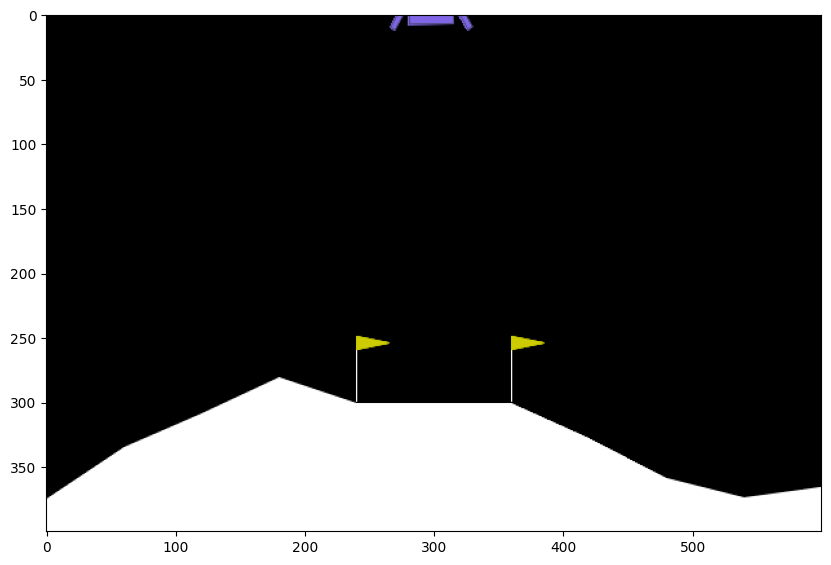

In [ ]:


env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,render_mode = "rgb_array")
env.reset()
frame = env.render()
fig,ax = plt.subplots(nrows=1,ncols=1,figsize = (10,10))
ax.imshow(frame)

In [ ]:
state_space = env.observation_space.shape[0]
action_space = env.action_space.n
print(state_space,action_space)

8 4


In [ ]:
num_envs = 8
p_env = gym.vector.SyncVectorEnv(
    [lambda: gym.make("LunarLander-v3") for _ in range(num_envs)]
)
seed_everything(p_env)

In [ ]:

def StateValueNetwork():
  state_value_network = nn.Sequential(
    nn.Linear(state_space,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,1)
  )

  return state_value_network

In [ ]:

def AdvantageNetwork():
  advantage_network = nn.Sequential(
    nn.Linear(state_space,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,action_space),
    nn.Softmax(dim=-1)
  )

  return advantage_network

In [ ]:
def A2C(StateValueNetwork,AdvantageValueNetwork,episodes,alpha1=1e-3,alpha2=1e-3,discount_factor = 0.99,entropy_weight = 0.0005):

  state_value_network = StateValueNetwork()
  advantage_network = AdvantageValueNetwork()
  state_value_network_optimizer = torch.optim.AdamW(state_value_network.parameters(),lr = alpha1)
  advantage_network_optimizer = torch.optim.AdamW(advantage_network.parameters(),lr = alpha2)
  returns_overtime = []

  for episode in tqdm(range(1, episodes + 1)):
    state_vector,_  = p_env.reset()
    state_vector = torch.tensor(state_vector).float()
    done = torch.zeros((num_envs, 1), dtype=torch.bool)
    rewards = torch.zeros((num_envs, 1)).float()
    punishment_for_early_bad_action = 1

    while not done.all():
      action_chosen = advantage_network(state_vector).multinomial(1).detach()
      next_state_vector, reward_vector, terminated_vector, truncated_vector , _ = p_env.step(action_chosen.detach().squeeze(1).cpu().numpy())
      next_state_vector = torch.tensor(next_state_vector).float()
      reward_vector = torch.tensor(reward_vector).unsqueeze(1).float()
      terminated_vector = torch.tensor(terminated_vector,dtype = torch.bool).unsqueeze(1)
      truncated_vector = torch.tensor(truncated_vector,dtype = torch.bool).unsqueeze(1)

      done_vector = terminated_vector | truncated_vector

      current_state_value = state_value_network(state_vector)
      next_state_value = state_value_network(next_state_vector).detach()
      target_value = reward_vector + ~done_vector * discount_factor * next_state_value
      lossFunction = F.mse_loss(current_state_value, target_value)
      state_value_network_optimizer.zero_grad()
      lossFunction.backward()
      state_value_network_optimizer.step()

      advantage = (target_value - current_state_value).detach()
      action_probablities = advantage_network(state_vector)
      log_action_probablities = torch.log(action_probablities+1e-6)
      chosen_action_logs = log_action_probablities.gather(1, action_chosen)
      entropy = - torch.sum(action_probablities * log_action_probablities, dim=-1, keepdim=True)
      policy_optimization_function = -(punishment_for_early_bad_action * advantage * chosen_action_logs) - (entropy_weight * entropy)

      policy_optimization_function = policy_optimization_function.mean()
      advantage_network_optimizer.zero_grad()
      policy_optimization_function.backward()
      advantage_network_optimizer.step()

      state_vector = next_state_vector
      rewards += reward_vector
      done |= done_vector
      punishment_for_early_bad_action *= discount_factor

    returns_overtime.append(rewards.mean().item())

  return returns_overtime



100%|██████████| 750/750 [40:56<00:00,  3.27s/it]


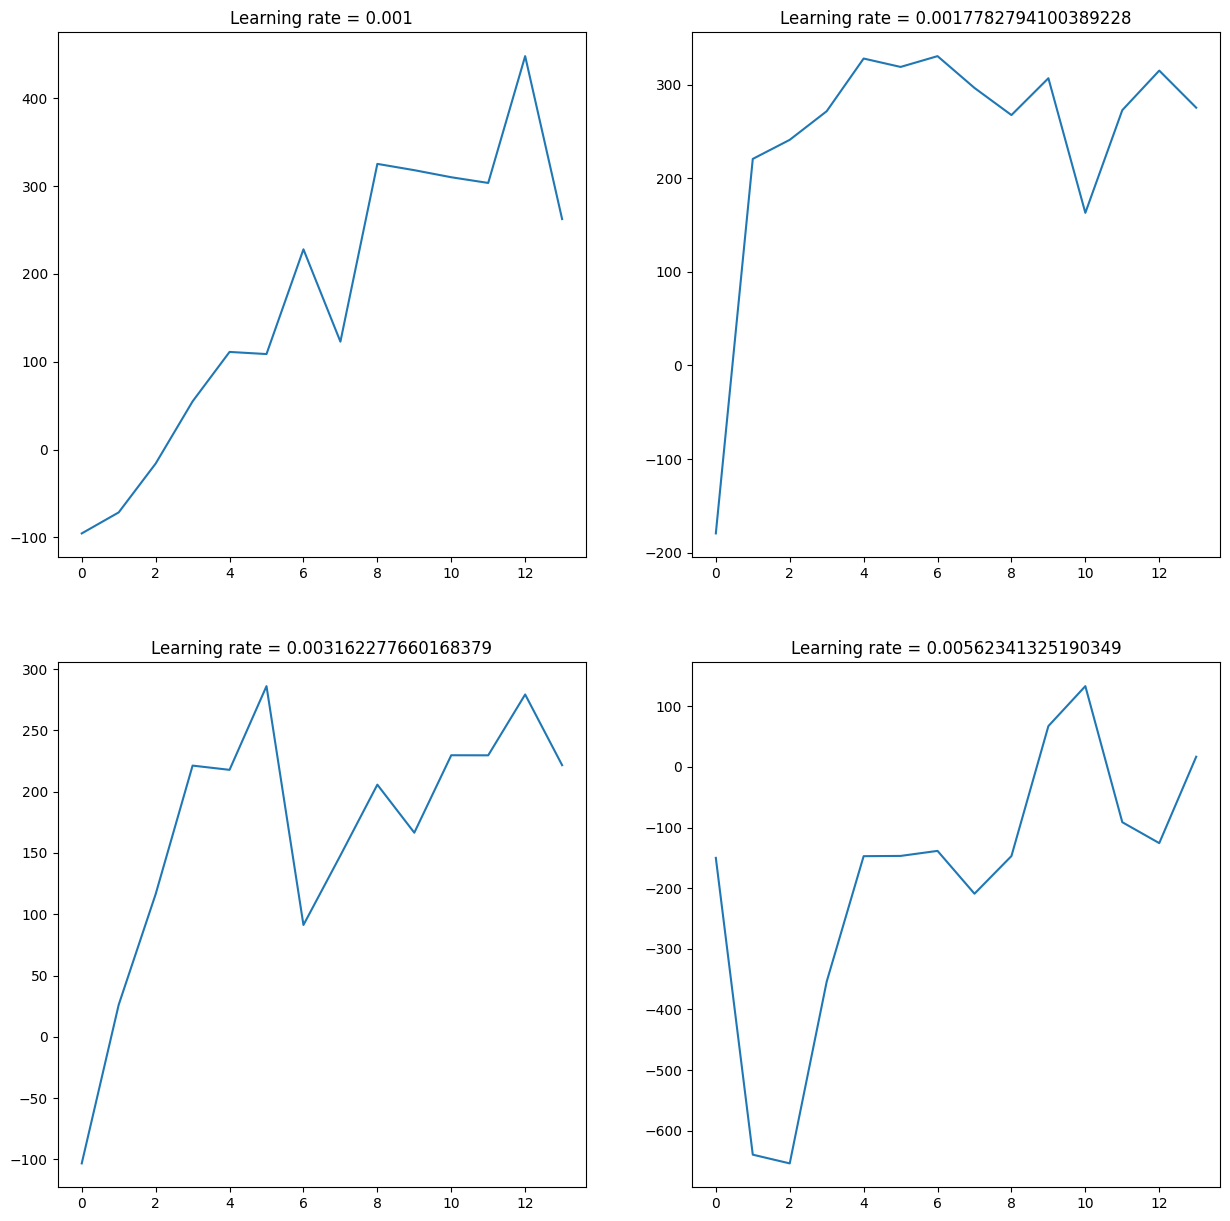

In [ ]:
fig , axes = plt.subplots(nrows = 2 , ncols = 2 , figsize = (15,15))
constant = 10 ** (1/4)
alpha = 0.001
alpha_variable = alpha
for i in range (0,2):
  for j in range (0,2):
    mean_list = []

    returns_overtime = A2C(StateValueNetwork,AdvantageNetwork,750,alpha,alpha_variable,0.99,0.0007)

    for index in range(0,len(returns_overtime)):
      if(index % 50 == 0 and index != 0):
        mean_list.append(np.mean(returns_overtime[index-50:index]))

        axes[i][j].set_title(f'Learning rate = {alpha_variable}')


    alpha_variable *= constant
    axes[i][j].plot(mean_list)
plt.show()



In [ ]:
mean_list

[np.float64(-150.0609620666504),
 np.float64(-639.4457391357422),
 np.float64(-653.8667248535156),
 np.float64(-354.14709014892577),
 np.float64(-147.27634613037108),
 np.float64(-146.85823791503907),
 np.float64(-138.54932159423828),
 np.float64(-209.14834075927735),
 np.float64(-147.05261848449706),
 np.float64(67.24953147888183),
 np.float64(133.0866780090332),
 np.float64(-91.26448795318603),
 np.float64(-125.76480834960938),
 np.float64(16.691061997413634)]